In [39]:
import pandas as pd

from helper import *
import ppscore as pps
import seaborn as sns
import matplotlib.pyplot as plt
from feature_selection import *
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Predictive Power Score
Use PPS score to discern the most important features from each omics dataset.

The PPS is an asymmetric, data-type-agnostic score that can detect linear or non-linear relationships between two columns. The score ranges from 0 (no predictive power) to 1 (perfect predictive power). It can be used as an alternative to the correlation (matrix).



In [40]:
lipidomics, metabolomics, proteomics = load_data()

lipidomics, _ = get_train_test_split_dataset(lipidomics)
metabolomics, _ = get_train_test_split_dataset(metabolomics)
proteomics, _ = get_train_test_split_dataset(proteomics)

print("Lipidomics: ", lipidomics.shape)
print("Metabolomics: ", metabolomics.shape)
print("Proteomics: ", proteomics.shape)

metabolomics = pareto_scaling(metabolomics)
proteomics = pareto_scaling(proteomics)

Training set shape:  (58, 581)
Testing set shape:  (38, 581)
Training set shape:  (58, 216)
Testing set shape:  (38, 216)
Training set shape:  (58, 323)
Testing set shape:  (38, 323)
Lipidomics:  (58, 581)
Metabolomics:  (58, 216)
Proteomics:  (58, 323)


In [41]:
def describe_PPS(data):
    data = data.copy()
    try:
        data = data.drop(['RID'], axis=1)
        data = data.drop(['TwoClass'], axis=1)
    except KeyError:
        pass
    
    significant_df = pd.DataFrame(columns=['Feature', 'PPS'])
    
    for feature in data.columns:
        if feature != 'ThreeClass':
            PPS = pps.score(data, feature, "ThreeClass")
            if PPS['ppscore'] > 0.01:
                significant_df = significant_df.append({
                    'Feature': feature, 
                    'PPS': PPS['ppscore']}, ignore_index=True)
                
    significant_df = significant_df.sort_values(by='PPS', ascending=False)
    
    significant_features = significant_df[significant_df['PPS'] > 0.1]
    print(
        'Number of significant features: ', significant_features.shape[0],
        ' out of ', data.shape[1])

    return significant_df

In [42]:
def plot_PPS(significant_df, title=None, palette='crest'):
    plt.figure(figsize=(7, 4))
    sns.barplot(
        x='PPS', y='Feature', data=significant_df[:12],
        palette=palette, orient='h')
    if title is None:
        title = 'PPS score for top 12 features'
    plt.title(title)
    # Set x limits (0, 1)
    plt.xlim(0, 1)
    
    plt.show()

### Here the new features will be saved
Array consists of features from all omics datasets that have a high PPS score

In [43]:
significant_features = []
# Number of features to be selected from each omics dataset
n = 5

# Lipidomics

Number of features:  581
Number of significant features:  9  out of  579


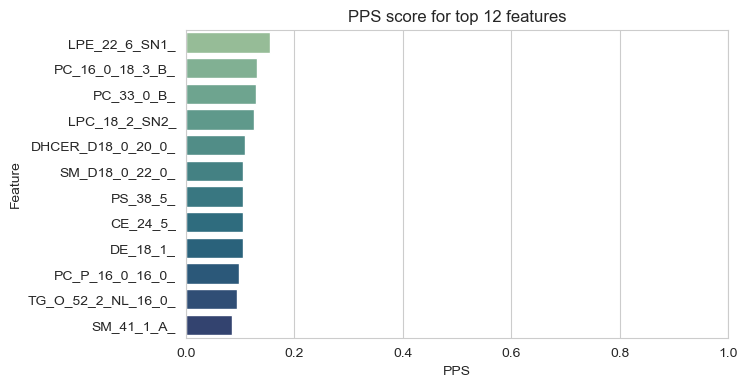

In [44]:
print("Number of features: ", lipidomics.shape[1])

significant_lipidomics = describe_PPS(lipidomics)
plot_PPS(significant_lipidomics)

significant_features.append(significant_lipidomics['Feature'][:n])

# Metabolomics

Number of features:  215
Number of significant features:  4  out of  214


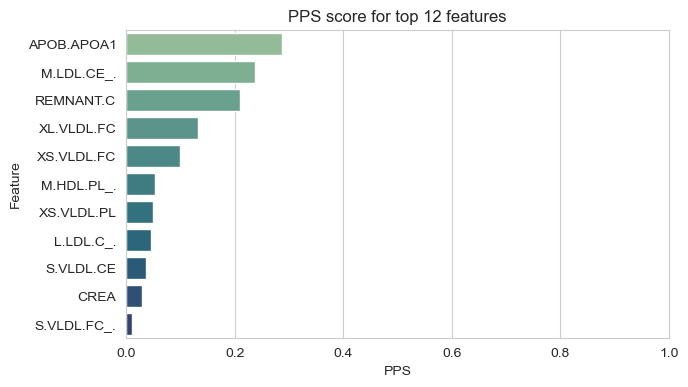

In [45]:
print("Number of features: ", metabolomics.shape[1])

significant_metabolomics = describe_PPS(metabolomics)
plot_PPS(significant_metabolomics)

significant_features.append(significant_metabolomics['Feature'][:n])

# Proteomics

Number of features:  322
Number of significant features:  5  out of  321


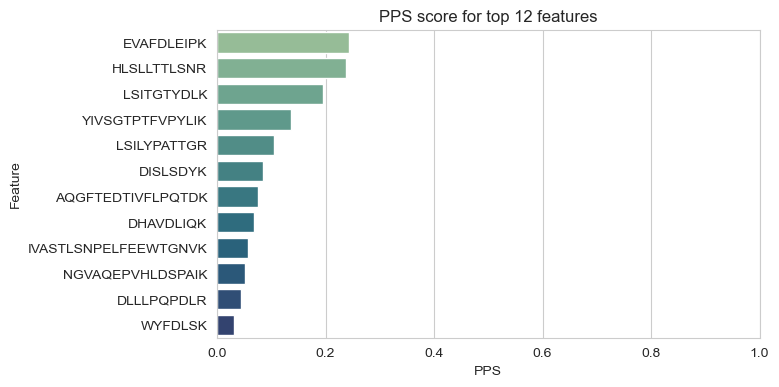

In [46]:
print("Number of features: ", proteomics.shape[1])

significant_proteomics = describe_PPS(proteomics)
plot_PPS(significant_proteomics)

significant_features.append(significant_proteomics['Feature'][:n])

In [47]:
anova = filter_omics(proteomics, 0.2, 'ANOVA')
print("ANOVA:", len(anova.columns))
inters_anova = anova.columns.intersection(significant_proteomics['Feature'])
print("Intersection: ", inters_anova)

mutual_info = filter_omics(proteomics, 0.2, 'MIFS')
print("\nMutual info:", len(mutual_info.columns))
inters_mi = mutual_info.columns.intersection(significant_proteomics['Feature'])
print("Intersection: ", inters_mi)

rfe = filter_omics(proteomics, 0.2, 'RFE')
print("\nRFE:", len(rfe.columns))
inters_rfe = rfe.columns.intersection(significant_proteomics['Feature'])
print("Intersection: ", inters_rfe)

ANOVA: 66
Intersection:  Index(['NGVAQEPVHLDSPAIK', 'EVAFDLEIPK', 'HLSLLTTLSNR'], dtype='object')

Mutual info: 66
Intersection:  Index(['LSITGTYDLK', 'DLLLPQPDLR', 'VDNAPDQQNSHPDLAQEEIR', 'DHAVDLIQK',
       'EVAFDLEIPK', 'DLFIDGQSK', 'LSILYPATTGR'],
      dtype='object')

RFE: 66
Intersection:  Index(['DHAVDLIQK'], dtype='object')


# Results

In [48]:
for i in range(3):
    print(significant_features[i].values)

['LPE_22_6_SN1_' 'PC_16_0_18_3_B_' 'PC_33_0_B_' 'LPC_18_2_SN2_'
 'DHCER_D18_0_20_0_']
['APOB.APOA1' 'M.LDL.CE_.' 'REMNANT.C' 'XL.VLDL.FC' 'XS.VLDL.FC']
['EVAFDLEIPK' 'HLSLLTTLSNR' 'LSITGTYDLK' 'YIVSGTPTFVPYLIK' 'LSILYPATTGR']
